In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Daily Minimum Temperatures in Melbourne

- https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv
- It contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990

In [3]:
def plot_series(time, series, colour,format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end],format, label=label,color=colour)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [4]:
df = pd.read_csv('Datasets/daily-min-temperatures.csv')
print(df.shape)
df.head()

(3650, 2)


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


(3650,) (3650,)


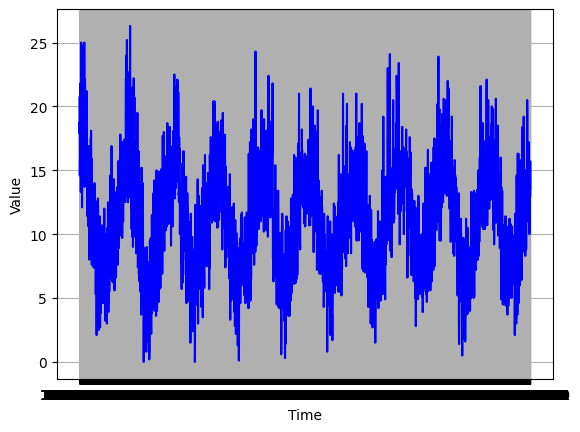

In [6]:
time = df.iloc[:,0].values
series = df.iloc[:,1].values
print(time.shape,series.shape)
plot_series(time, series,'b')

In [7]:
# Take the first 2500 points for training while the rest is for validation
split_idx = 2500
time_y_train = time[0:split_idx]
series_x_train = series[0:split_idx]

time_y_val = time[split_idx:]
series_x_val = series[split_idx:]

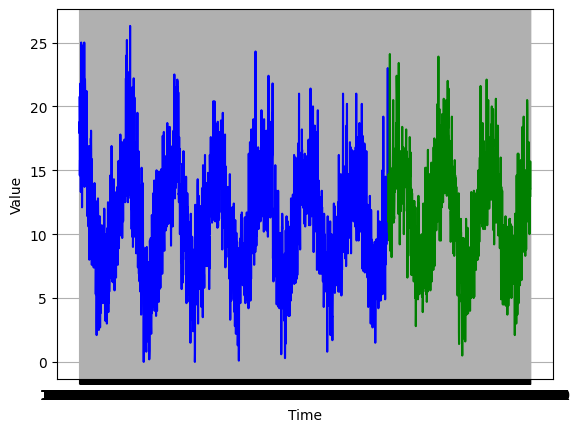

In [8]:
plot_series(time_y_train,series_x_train,'b')
plot_series(time_y_val,series_x_val,'g')

In [9]:
window_size = 64
batch_size = 256

In [10]:
def windowing(series,window_size,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size+1,shift=1,drop_remainder=True) #Returns WindowDataset & Iterator returns VariantDataset
    dataset = dataset.flat_map(lambda el : el.batch(window_size+1))  #Flatten windows  by putting its elements in a single batch so that it gives a single dataset -> Returns FlatMapDataset & Iterator returns Tensor
    dataset = dataset.map(lambda el : (el[:-1],el[-1:])) #Returns MapDataset & Iterator returns 2 tensors #el[-1] returns scalar while el[-1:] returns array
    dataset = dataset.shuffle(buffer_size=len(series)+10)
    dataset =dataset.batch(batch_size=batch_size).prefetch(1) #Simply specify the batch size and it will return a batched dataset with that number of windows
    return dataset

train_ds = windowing(series_x_train,window_size=window_size,batch_size=batch_size) #Iterate as for x,y in dataset:
val_ds = windowing(series_x_val,window_size=window_size,batch_size=batch_size)
for x,y in train_ds:
    print(x.numpy().shape,y.numpy().shape)

2022-10-26 09:41:02.342361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(256, 64) (256, 1)
(256, 64) (256, 1)
(256, 64) (256, 1)
(256, 64) (256, 1)
(256, 64) (256, 1)
(256, 64) (256, 1)
(256, 64) (256, 1)
(256, 64) (256, 1)
(256, 64) (256, 1)
(132, 64) (132, 1)


In [11]:
train_ds = train_ds.map(lambda x,y : (tf.expand_dims(x,axis=-1),y))
test_ds = train_ds.map(lambda x,y : (tf.expand_dims(x,axis=-1),y))
for x,y in train_ds:
    print(x.numpy().shape,y.numpy().shape)

(256, 64, 1) (256, 1)
(256, 64, 1) (256, 1)
(256, 64, 1) (256, 1)
(256, 64, 1) (256, 1)
(256, 64, 1) (256, 1)
(256, 64, 1) (256, 1)
(256, 64, 1) (256, 1)
(256, 64, 1) (256, 1)
(256, 64, 1) (256, 1)
(132, 64, 1) (132, 1)


In [12]:
ts_cnn_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,kernel_size=3,padding='causal',activation='relu',input_shape=[None,1]),
    #tf.keras.layers.GlobalMaxPooling1D(),

    tf.keras.layers.LSTM(units=32,return_sequences=True),
    tf.keras.layers.LSTM(units=32),

    tf.keras.layers.Dense(units=32,activation='relu'),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Dense(units=1)
])
ts_cnn_rnn_model.summary()
ts_cnn_rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.Huber(),metrics=['mae']) #Huber minimize sensitivity to outliers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          256       
                                                                 
 lstm (LSTM)                 (None, None, 32)          12416     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,137
Trainable params: 23,137
Non-traina

In [13]:
ts_cnn_rnn_model_hist = ts_cnn_rnn_model.fit(train_ds,epochs = 300)

Epoch 1/300
10/10 [==============================] - 6s 190ms/step - loss: 10.3867 - mae: 10.8861
Epoch 2/300
10/10 [==============================] - 2s 153ms/step - loss: 10.1939 - mae: 10.6930
Epoch 3/300
10/10 [==============================] - 2s 130ms/step - loss: 10.0024 - mae: 10.5012
Epoch 4/300
10/10 [==============================] - 2s 153ms/step - loss: 9.8018 - mae: 10.3004
Epoch 5/300
10/10 [==============================] - 2s 125ms/step - loss: 9.5906 - mae: 10.0891
Epoch 6/300
10/10 [==============================] - 2s 116ms/step - loss: 9.3610 - mae: 9.8593
Epoch 7/300
10/10 [==============================] - 2s 116ms/step - loss: 9.1223 - mae: 9.6207
Epoch 8/300
10/10 [==============================] - 1s 110ms/step - loss: 8.8657 - mae: 9.3640
Epoch 9/300
10/10 [==============================] - 2s 109ms/step - loss: 8.5795 - mae: 9.0775
Epoch 10/300
10/10 [==============================] - 2s 121ms/step - loss: 8.2610 - mae: 8.7589
Epoch 11/300
10/10 [===========

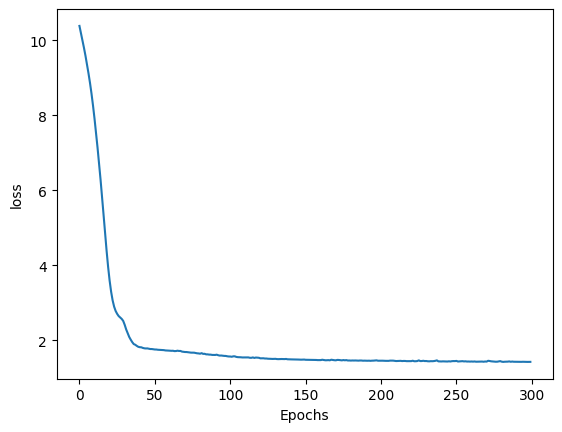

In [14]:
def plot_graphs(model_hist, string):
  plt.plot(model_hist.history[string])
  #plt.plot(model_hist.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  #plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(ts_cnn_rnn_model_hist, "loss")

In [15]:
predict_ds = tf.data.Dataset.from_tensor_slices(series[split_idx-window_size:])
predict_ds = predict_ds.window(size=window_size+1,shift=1,drop_remainder=True)
predict_ds = predict_ds.flat_map(lambda el : el.batch(window_size+1))
predict_ds = predict_ds.map(lambda el : el[:-1])
predict_ds = predict_ds.batch(batch_size=batch_size).prefetch(1)

In [16]:
ts_cnn_rnn_model_forecast = ts_cnn_rnn_model.predict(predict_ds)
ts_cnn_rnn_model_forecast = ts_cnn_rnn_model_forecast.reshape(-1)

5/5 [==============================] - 1s 68ms/step


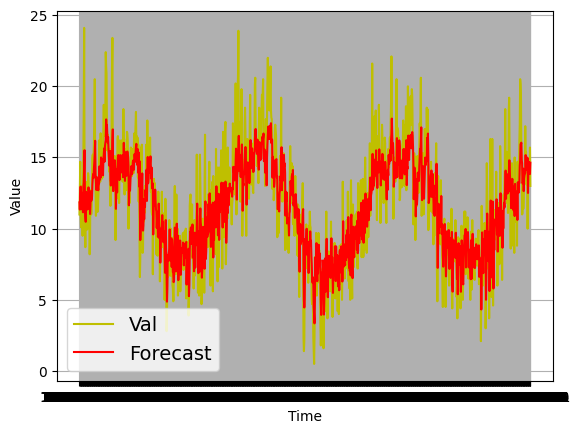

In [17]:
plot_series(time_y_val,series_x_val,colour='y',label='Val')
plot_series(time_y_val,ts_cnn_rnn_model_forecast,colour='r',label='Forecast')

In [18]:
print(tf.keras.metrics.mean_absolute_error(series_x_val,ts_cnn_rnn_model_forecast).numpy())

1.7955123
